In [1]:
import astropy
from astropy.table import Table, join, vstack
from astropy.time import Time
from astropy.io import fits
from astropy import units as u

from astroquery.jplhorizons import Horizons

import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import time
import requests
import sys
import os
import getpass

saveplots = False # set to save some of the plots to png files
import pandas as pd
from astropy.time import Time
from astropy.coordinates import SkyCoord
from urllib.parse import quote

# Functions

In [2]:
def cadc_ssos_query(object_name, search="bynameall", 
                    # epoch1=50000, epoch2=57079,
                    xyres="no", 
                    # telinst="Pan-STARRS1", 
                    lang="en", format="tsv",
                    url="https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl"):
    """Use CADC moving object query to find PS1 observations by target name
    
    The epoch parameters give the range in MJD for the PS1 observations.
    The only parameter that might be usefully modified is the search.  
    E.g., use search="bynameHorizons" to search using the JPL Horizons emphemeris rather
    than the ephemeris cached at CADC.  That might be useful if the CADC cache has become
    out-of-date.
    
    This return an astropy table with the observations.
    """
    t0 = Time('1990-01-01 00:00:00', format='iso', scale='utc')
    t1 = Time.now()

    print(f"Querying CADC SSOS for object '{object_name}' between {t0.iso} and {t1.iso}")
    params = dict(
        lang=lang,
        object=object_name,
        search=search,
        epoch1=t0.mjd,
        epoch2=t1.mjd,
        format=format
    )

    try:
        r = requests.get(url, params=params, timeout=60)
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {e}")
        # Return an empty table with expected columns so downstream code doesn't crash
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    print(r.url)

    text = r.text
    first_line = text.strip().split('\n', 1)[0]

    # Detect common error responses from CADC / Horizons and HTML error pages
    if (first_line.lower().startswith("there was an error") or
        "error" in first_line.lower() or
        first_line.strip().startswith("<!DOCTYPE") or
        first_line.strip().startswith("<html")):
        # Clean up message for printing
        msg = first_line.replace('<br/>', '').strip()
        print(f"CADC/SSOS returned an error: {msg}")
        # Try a simple fallback: switch to CADC cached ephemerides if not already using it
        if search != "bynameCADC":
            print("Retrying with search='bynameCADC'...")
            return cadc_ssos_query(object_name, search="bynameCADC", xyres=xyres, lang=lang, format=format, url=url)
        # Otherwise return an empty table with expected columns
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    # Parse TSV using pandas to avoid astropy fast C-reader converter limitations
    try:
        df = pd.read_csv(StringIO(text), sep='\t', engine='python', on_bad_lines='skip')
    except Exception as e:
        print(f"Failed to parse CADC TSV: {e}")
        # Return empty table with expected columns to keep pipeline running
        cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
        return Table.from_pandas(pd.DataFrame(columns=cols))

    # Ensure expected columns exist even if CADC response changes
    expected_cols = ['Image', 'MJD', 'Filter', 'Exptime', 'Object_RA', 'Object_Dec',
                     'Image_target', 'Telescope/Instrument', 'MetaData', 'Datalink']
    for col in expected_cols:
        if col not in df.columns:
            df[col] = pd.NA

    # Ensure string type for Image_target if present
    if 'Image_target' in df.columns:
        df['Image_target'] = df['Image_target'].astype(str)

    return Table.from_pandas(df)



In [3]:
# Define a simple ephemerides query
def ephemcc(ident, ep, nbd=None, step=None, observer='645', rplane='1', tcoor=5):
    '''Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    '''
    
    # ------
    # Miriade URL 
    url = 'https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php'
    
    #if rplane=='2':
    #    tcoor='1'
        
    # Query parameters
    params = {
        '-name': f'c:{ident}',
        '-mime': 'json',
        '-rplane': rplane,
        '-tcoor': tcoor,
        '-output': '--jd',
        '-observer': observer, 
        '-tscale': 'UTC',
        '-type': 'Asteroid'
    }
    

    # Single epoch of computation
    if type(ep)!=list:
        # Set parameters
        params['-ep'] = ep
        if nbd!=None: 
            params['-nbd'] = nbd
        if step!=None: 
            params['-step'] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False


    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {'epochs': ('epochs', '\n'.join(['%.6f' % epoch
                                                 for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=120)
            print(r.url)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j['data'])
    except KeyError:
        return False

    return ephem


# Telescopes visibility from Telescope limits

In [50]:
df_limits = pd.read_csv("data/Survey-Filter-LimitingMagnitude-SaturationMagnitude-TypicalExposureTime.csv")
df_limits

,Telescope/Instrument,Filter,Limiting,Saturation,Exposure
0,Pan-STARRS1,g,21.5,14.5,45
1,Pan-STARRS1,r,21.5,14.5,45
2,Pan-STARRS1,i,21.5,14.5,45
3,Pan-STARRS1,z,20.9,14.5,45
4,Pan-STARRS1,y,19.7,14.5,45
5,SDSS,g,23.3,14.0,54
6,SDSS,u,22.3,14.0,54
7,SDSS,r,23.1,14.0,54
8,SDSS,i,22.3,14.0,54
9,SDSS,z,20.8,14.0,54


# List of the comets

In [3]:
df_init = pd.read_csv('data/List of comets.csv')
df_init

,Comet name,q,e,Tq,year of observations
0,C/2021 S3,1.320,1.00025,14.02.2024,"2024, 2025"
1,C/2019 L3,3.550,1.00141,09.01.2022,"2024, 2025"
2,C/2019 U5,3.620,1.00142,29.03.2023,"2024, 2025"
3,C/2022 N2,3.830,1.00356,31.07.25,"2024, 2025"
4,C/2019 T4,4.240,0.99562,08.06.2022,"2024, 2025"
5,C/2017 K2,1.800,1.00060,19.12.2022,"2020, 2021, 2024, 2025"
6,C/2022 QE78,5.480,1.00405,10.09.2025,"2024, 2025"
7,C/2022 E2,3.670,1.00073,14.09.2024,"2024, 2025"
8,C/2024 E1,0.566,1.00005,20.01.2026,"2024, 2025"
9,C/2021 G2,4.982,1.00011,09.09.2024,"2024, 2025"


# Read tables from CADC

In [73]:
%%time 
for i, row in df_init.iterrows():
    print(f"{i}: {row['Comet name']}")
    source = df_init.loc[i, 'Comet name']
    name = " ".join(source.split())

    cadc_tab = cadc_ssos_query(name)
    print(f"Returned table has {len(cadc_tab)} rows")
    df_comet = cadc_tab.to_pandas()
    df_comet.to_csv(f"data/cadc/{name.replace('/', '_')}_cadc.csv", index=False)
    # break



0: C/2021 S3
Querying CADC SSOS for object 'C/2021 S3' between 1990-01-01 00:00:00.000 and 2025-09-22 11:51:56.764
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2021+S3&search=bynameall&epoch1=47892.0&epoch2=60940.49440698593&format=tsv
Returned table has 2400 rows
1: C/2019 L3
Querying CADC SSOS for object 'C/2019 L3' between 1990-01-01 00:00:00.000 and 2025-09-22 11:52:03.622
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2019+L3&search=bynameall&epoch1=47892.0&epoch2=60940.49448636738&format=tsv
Returned table has 2724 rows
2: C/2019 U5
Querying CADC SSOS for object 'C/2019 U5' between 1990-01-01 00:00:00.000 and 2025-09-22 11:52:11.453
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=C%2F2019+U5&search=bynameall&epoch1=47892.0&epoch2=60940.49457700529&format=tsv
Returned table has 1826 rows
3: C/2022 N2
Querying CADC SSOS for object 'C/2022 N2' between 1990-01-01 00

# Check Miriade

In [16]:
rows_limit = 500
for i, row in df_init[1:].iterrows():
    print(f"{i}: {row['Comet name']}")
    source = df_init.loc[i, 'Comet name']
    name = " ".join(source.split())
    filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
    df_obs = pd.read_csv(filename)
    
    chunks = len(df_obs) // rows_limit + 1
    print(f"  Read {len(df_obs)} observations from {filename} in {chunks} chunks")

    df_comet = None
    for chunk in range(chunks):
        start = chunk * rows_limit
        end = min((chunk + 1) * rows_limit, len(df_obs))
        jds = (df_obs['MJD'].values[start:end] + 2400000.5).tolist()
        
        ephem = ephemcc(name, jds, observer='500', rplane='1', tcoor=5)
        if ephem is False:
            print(f"  Miriade query failed for {name}")
            continue
        
        if df_comet is None:
            df_comet = ephem
        else:
            df_comet = pd.concat([df_comet, ephem], ignore_index=True)

    if df_comet is not None:
        print(f"Got {len(df_comet)} ephemeris rows from Miriade")
        df_comet.to_csv(f"data/miriade/{name.replace('/', '_')}_miriade.csv", index=False)

    

1: C/2019 L3
  Read 2724 observations from data/cadc/C_2019 L3_cadc.csv in 6 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2019+L3&-mime=json&-rplane=1&-

# Analysis of the results

In [36]:
counts = 0
for i, row in df_init[0:].iterrows():
    name = " ".join(row['Comet name'].split())
    cadc_filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
    miriade_filename = f"data/miriade/{name.replace('/', '_')}_miriade.csv"
    try:
        df_cadc = pd.read_csv(cadc_filename)
    except FileNotFoundError:
        print(f"{name}: CADC file not found")
        continue
    
    try:
        df_miriade = pd.read_csv(miriade_filename)
    except FileNotFoundError:
        print(f"{name}: Miriade file not found")
        continue
    
    df = pd.merge(df_cadc, df_miriade, left_index=True, right_index=True, suffixes=('_cadc', '_miriade'))
    print(f"{name}: merged {len(df)} rows")
    
    cond = (df['VMag'] < 18) & (df["Telescope/Instrument"] == "NEOSSat")
    df_visible = df[cond]
    counts += len(df_visible)
    # break
print(f"Total visible observations: {counts}")

C/2021 S3: merged 2400 rows
C/2019 L3: merged 2724 rows
C/2019 U5: merged 1826 rows
C/2022 N2: merged 2802 rows
C/2019 T4: merged 1769 rows
C/2017 K2: merged 7173 rows
C/2022 QE78: merged 2666 rows
C/2022 E2: merged 1331 rows
C/2024 E1: merged 1362 rows
C/2021 G2: merged 1582 rows
C/2023 Q1: Miriade file not found
C/2023 H5: merged 921 rows
C/2010 U3: merged 662 rows
C/2012 K2: Miriade file not found
C/2013 V2: merged 607 rows
C/2014 N3: merged 646 rows
C/2014 S2: merged 679 rows
C/2014 W2: merged 726 rows
C/2015 O1: merged 973 rows
C/2015 V2: merged 1210 rows
C/2015 VL62: Miriade file not found
C/2016 N4: merged 1650 rows
C/2017 O1: merged 4258 rows
C/2018 N2: merged 1730 rows
C/2018 U1: merged 1119 rows
C/2020 M3: merged 1306 rows
C/2020 T2: merged 1214 rows
C/2021 A2: merged 957 rows
110P: merged 2528 rows
114P: merged 1404 rows
123P: merged 1237 rows
12P: merged 2387 rows
156P: merged 1173 rows
201P: merged 2542 rows
21P: merged 1775 rows
230P: merged 689 rows
260P: merged 1821 row

In [34]:
df_visible.value_counts('Telescope/Instrument')

Telescope/Instrument
NEOSSat              1533
LCO/lsc_1m0a_fa15      13
ESA-CAHA               12
CTIO-4m/DECam           8
ESA-TBT-LaSilla         8
LCO/lsc_0m4a_kb29       8
LCO/coj_2m0a_fs01       6
LCO/cpt_1m0a_fa16       6
CFHT/MegaCam            5
LCO/cpt_1m0a_fa06       4
LCO/lsc_1m0a_fa04       4
LCO/tfn_1m0a_fa20       4
ALMA                    1
Name: count, dtype: int64

In [ ]:
# for i, row in df_init[5:].iterrows():
#     name = " ".join(row['Comet name'].split())
#     cadc_filename = f"data/cadc/{name.replace('/', '_')}_cadc.csv"
#     miriade_filename = f"data/miriade/{name.replace('/', '_')}_miriade.csv"

Telescope/Instrument
NEOSSat              1443
ZTF                   403
CFHT/MegaCam          108
ESA-CAHA               99
LCO/tfn_0m4a_kb95      88
LCO/tfn_0m4b_kb56      68
HST/WFC3               63
ESA-TBT-LaSilla        60
LCO/tfn_0m4b_kb98      50
LCO/elp_1m0a_fa05      43
LCO/elp_0m4a_kb92      38
LCO/lsc_0m4a_kb98      30
ALMA                   23
Gemini/GMOS            21
LCO/ogg_0m4b_kb27      20
LCO/tfn_0m4a_kb81      20
LCO/cpt_1m0a_fa06      18
LCO/lsc_0m4a_kb26      18
LCO/elp_0m4a_kb55      16
LCO/cpt_1m0a_fa16      15
LCO/lsc_1m0a_fa15      15
WHT/AUXCAM             10
HST/ACS                10
CTIO-4m/DECam           8
LCO/coj_1m0a_fa12       7
ESA-TBT-Cebreros        6
LCO/tfn_1m0a_fa11       4
LCO/elp_1m0a_fa07       4
LCO/tfn_0m4b_kb23       4
LCO/coj_0m4a_kb26       4
LCO/lsc_1m0a_fa04       3
LCO/tfn_1m0a_fa20       3
ESA-Tautenburg          2
LCO/lsc_0m4a_kb29       2
LCO/tfn_0m4a_kb25       2
Name: count, dtype: int64

# New list of the comets

In [10]:
l2 = "C/2004 D1, C/2005 R4, C/2005 T3, C/2006 L1, C/2006 Q1, C/2007 N3, C/2007 R1, C/2008 FK75, C/2009 F2, C/2009 S3, C/2009 U5, C/2010 G2, C/2012 A1, C/2016 R2, C/2023 H5"
df_init = pd.DataFrame({"Comet": l2.split(", ")})
df_init

,Comet
0,C/2004 D1
1,C/2005 R4
2,C/2005 T3
3,C/2006 L1
4,C/2006 Q1
5,C/2007 N3
6,C/2007 R1
7,C/2008 FK75
8,C/2009 F2
9,C/2009 S3


## Get possible dates of observation from CADC

In [12]:
%%time 
for i, row in df_init.iterrows():
    print(f"{i}: {row['Comet']}")
    source = df_init.loc[i, 'Comet']
    name = " ".join(source.split())
    cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    if os.path.exists(cadc_filename):
        print(f"  File {cadc_filename} exists, skipping")
        continue

    cadc_tab = cadc_ssos_query(name)
    
    print(f"Returned table has {len(cadc_tab)} rows")
    df_comet = cadc_tab.to_pandas()
    df_comet.to_csv(cadc_filename, index=False)
    # break


0: C/2004 D1
  File data/cadc2/C_2004 D1_cadc.csv exists, skipping
1: C/2005 R4
  File data/cadc2/C_2005 R4_cadc.csv exists, skipping
2: C/2005 T3
  File data/cadc2/C_2005 T3_cadc.csv exists, skipping
3: C/2006 L1
  File data/cadc2/C_2006 L1_cadc.csv exists, skipping
4: C/2006 Q1
  File data/cadc2/C_2006 Q1_cadc.csv exists, skipping
5: C/2007 N3
  File data/cadc2/C_2007 N3_cadc.csv exists, skipping
6: C/2007 R1
  File data/cadc2/C_2007 R1_cadc.csv exists, skipping
7: C/2008 FK75
  File data/cadc2/C_2008 FK75_cadc.csv exists, skipping
8: C/2009 F2
  File data/cadc2/C_2009 F2_cadc.csv exists, skipping
9: C/2009 S3
  File data/cadc2/C_2009 S3_cadc.csv exists, skipping
10: C/2009 U5
  File data/cadc2/C_2009 U5_cadc.csv exists, skipping
11: C/2010 G2
  File data/cadc2/C_2010 G2_cadc.csv exists, skipping
12: C/2012 A1
Querying CADC SSOS for object 'C/2012 A1' between 1990-01-01 00:00:00.000 and 2025-10-21 11:07:32.802
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=

## Get ephemerides from Miriade for the selected dates

In [13]:
rows_limit = 2000
for i, row in df_init[1:].iterrows():
    print(f"{i}: {row['Comet']}")
    source = df_init.loc[i, 'Comet']
    name = " ".join(source.split())
    cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    miriade_filename = f"data/miriade2/{name.replace('/', '_')}_miriade.csv"
    if os.path.exists(miriade_filename):
        print(f"  File {miriade_filename} exists, skipping")
        continue

    df_obs = pd.read_csv(cadc_filename)
    chunks = len(df_obs) // rows_limit + 1
    print(f"  Read {len(df_obs)} observations from {cadc_filename} in {chunks} chunks")

    df_comet = None
    for chunk in range(chunks):
        start = chunk * rows_limit
        end = min((chunk + 1) * rows_limit, len(df_obs))
        jds = (df_obs['MJD'].values[start:end] + 2400000.5).tolist()
        
        ephem = ephemcc(name, jds, observer='500', rplane='1', tcoor=5)
        if ephem is False:
            print(f"Miriade query failed for {name}")
            time.sleep(1)
            continue
        
        if df_comet is None:
            df_comet = ephem
        else:
            df_comet = pd.concat([df_comet, ephem], ignore_index=True)

    if df_comet is not None:
        print(f"Got {len(df_comet)} ephemeris rows from Miriade")
        df_comet.to_csv(miriade_filename, index=False)

1: C/2005 R4
  File data/miriade2/C_2005 R4_miriade.csv exists, skipping
2: C/2005 T3
  Read 1871 observations from data/cadc2/C_2005 T3_cadc.csv in 1 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2005+T3&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
Miriade query failed for C/2005 T3
3: C/2006 L1
  File data/miriade2/C_2006 L1_miriade.csv exists, skipping
4: C/2006 Q1
  File data/miriade2/C_2006 Q1_miriade.csv exists, skipping
5: C/2007 N3
  File data/miriade2/C_2007 N3_miriade.csv exists, skipping
6: C/2007 R1
  Read 899 observations from data/cadc2/C_2007 R1_cadc.csv in 1 chunks
https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?-name=c%3AC%2F2007+R1&-mime=json&-rplane=1&-tcoor=5&-output=--jd&-observer=500&-tscale=UTC&-type=Asteroid
Miriade query failed for C/2007 R1
7: C/2008 FK75
  File data/miriade2/C_2008 FK75_miriade.csv exists, skipping
8: C/2009 F2
  File data/miriade2/C_2009 F2_miriade.csv exists, sk

## Get ephemerides from JPL Horizons

In [14]:
for i, row in df_init.iterrows():
    print(f"{i}: {row['Comet']}")
    source = df_init.loc[i, 'Comet']
    name = " ".join(source.split())

    cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    jplh_filename = f"data/jpl2/{name.replace('/', '_')}_jplhorizons.csv"
    if not os.path.exists(cadc_filename):
        print(f"  CADC file {cadc_filename} not found, skipping")
        continue
    
    if os.path.exists(jplh_filename):
        print(f"  JPL Horizons file {jplh_filename} already exists, skipping")
        continue
    
    df_cadc = pd.read_csv(cadc_filename)

    emin = Time(df_cadc['MJD'].min(), format='mjd')
    emax = Time(df_cadc['MJD'].max(), format='mjd')

    print(f"Have {name} from {emin.isot} to {emax.isot} ({emax.mjd-emin.mjd:.0f} days)")

    # query using 1-day time steps
    obj = Horizons(id=name, location='500', 
                   epochs=dict(start=emin.isot, stop=emax.isot, step='1d'))#, 

    jpltab = obj.ephemerides(extra_precision=True)
    fullname = jpltab['targetname'][0]
    print(f"Got positions from Horizons with {len(jpltab)} rows for {fullname}")

    # save to CSV
    jpltab.to_pandas().to_csv(jplh_filename, index=False)


0: C/2004 D1
  JPL Horizons file data/jpl2/C_2004 D1_jplhorizons.csv already exists, skipping
1: C/2005 R4
  JPL Horizons file data/jpl2/C_2005 R4_jplhorizons.csv already exists, skipping
2: C/2005 T3
  JPL Horizons file data/jpl2/C_2005 T3_jplhorizons.csv already exists, skipping
3: C/2006 L1
  JPL Horizons file data/jpl2/C_2006 L1_jplhorizons.csv already exists, skipping
4: C/2006 Q1
  JPL Horizons file data/jpl2/C_2006 Q1_jplhorizons.csv already exists, skipping
5: C/2007 N3
  JPL Horizons file data/jpl2/C_2007 N3_jplhorizons.csv already exists, skipping
6: C/2007 R1
  JPL Horizons file data/jpl2/C_2007 R1_jplhorizons.csv already exists, skipping
7: C/2008 FK75
  JPL Horizons file data/jpl2/C_2008 FK75_jplhorizons.csv already exists, skipping
8: C/2009 F2
  JPL Horizons file data/jpl2/C_2009 F2_jplhorizons.csv already exists, skipping
9: C/2009 S3
  JPL Horizons file data/jpl2/C_2009 S3_jplhorizons.csv already exists, skipping
10: C/2009 U5
  JPL Horizons file data/jpl2/C_2009 U5_jp

## Analysis of the results

In [51]:
counts = 0
for i, row in df_init[0:].iterrows():
    is_cadc = False
    is_miriade = False
    is_jplh = False
    
    name = " ".join(row['Comet'].split())
    cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
    miriade_filename = f"data/miriade2/{name.replace('/', '_')}_miriade.csv"
    jplh_filename = f"data/jpl2/{name.replace('/', '_')}_jplhorizons.csv"
    try:
        df_cadc = pd.read_csv(cadc_filename)
        is_cadc = True
    except FileNotFoundError:
        print(f"{name}: CADC file not found")
        continue
    
    try:
        df_jplh = pd.read_csv(jplh_filename)
        is_jplh = True
    except FileNotFoundError:
        print(f"{name}: JPL Horizons file not found")
        # continue

    if is_jplh:
        df_merged = pd.merge(df_cadc, df_jplh, left_index=True, right_index=True, suffixes=('_cadc', '_jplh'))
    else:
        print(f"{name}: No JPL Horizons data to merge")
        continue
        
    # print(f"{name}: merged {len(df_merged)} rows")
    # display(df_merged[['Telescope/Instrument', 'Filter']].value_counts())

    # Keep only needed columns
    limits = df_limits[[c for c in ['Telescope/Instrument', 'Filter', 'Limiting', 'Saturation'] if c in df_limits.columns]].dropna(subset=['Telescope/Instrument'])

    # Keep only observations whose Telescope/Instrument exists in the limits
    valid_instr = set(limits['Telescope/Instrument'].unique())
    df_merged = df_merged[df_merged['Telescope/Instrument'].isin(valid_instr)].copy()

    # Attach limits to each observation; inner keeps only matched (Instrument, Filter)
    df_with_limits = df_merged.merge(limits, on=['Telescope/Instrument', 'Filter'], how='inner')

    # Condition: not saturated (Tmag >= Saturation) and not too faint (Tmag <= Limiting)
    cond = (df_with_limits['Tmag'] >= df_with_limits['Saturation']) & (df_with_limits['Tmag'] <= df_with_limits['Limiting'])

    df_visible = df_with_limits[cond]

    if len(df_visible) != 0:
        display(df_visible[['Telescope/Instrument', 'Filter']].value_counts())
        counts += len(df_visible)
    else:
        print(f"{name}: No visible observations")

    # if i == 2:
    #     break
print(f"Total visible observations: {counts}")

Telescope/Instrument  Filter
CTIO-4m/DECam         i         20
                      z         20
                      r         17
SDSS                  g         15
CTIO-4m/DECam         g          9
                      Y          4
Name: count, dtype: int64

C/2005 R4: No visible observations


Telescope/Instrument  Filter
CTIO-4m/DECam         r         228
                      z         208
                      i         206
                      g         141
ZTF                   zr         22
                      zg         17
SDSS                  g           2
Name: count, dtype: int64

C/2006 L1: No visible observations


Telescope/Instrument  Filter
ZTF                   zr        145
                      zg        130
SDSS                  g           2
                      i           2
                      r           2
                      u           2
Name: count, dtype: int64

C/2007 N3: No visible observations


Telescope/Instrument  Filter
ZTF                   zr        43
                      zg        42
CTIO-4m/DECam         g         39
                      r         23
                      z         12
SDSS                  g          1
ZTF                   zi         1
Name: count, dtype: int64

Telescope/Instrument  Filter
CTIO-4m/DECam         i         136
                      g         119
ZTF                   zr        118
CTIO-4m/DECam         z         109
                      r         101
ZTF                   zg         98
Pan-STARRS1           i          37
CTIO-4m/DECam         Y          30
Pan-STARRS1           y          27
                      r          21
                      g          18
                      z          17
ZTF                   zi          5
Name: count, dtype: int64

Telescope/Instrument  Filter
ZTF                   zr        147
                      zg        113
Pan-STARRS1           i          49
                      r          21
                      z          21
                      g          18
                      y          15
Name: count, dtype: int64

C/2009 S3: No visible observations


Telescope/Instrument  Filter
CTIO-4m/DECam         z         78
ZTF                   zg        60
                      zr        51
Pan-STARRS1           i         42
CTIO-4m/DECam         g         39
Pan-STARRS1           r         34
CTIO-4m/DECam         r         29
                      i         26
Pan-STARRS1           y         21
                      g         16
                      z         15
Name: count, dtype: int64

Telescope/Instrument  Filter
CTIO-4m/DECam         z         40
                      r         24
                      g         22
                      i         22
Name: count, dtype: int64

Telescope/Instrument  Filter
CTIO-4m/DECam         g         62
                      z         54
                      r         45
                      i         18
Name: count, dtype: int64

Telescope/Instrument  Filter
CTIO-4m/DECam         g         248
                      i          52
ZTF                   zr         50
                      zg         46
CTIO-4m/DECam         r          12
                      z           2
Name: count, dtype: int64

C/2023 H5: No visible observations
Total visible observations: 3681


# Plots

In [54]:
# name= "C/2023 H5"
# name = "C/2005 R4"
name = df_init.loc[1, 'Comet']
print(name)
cadc_filename = f"data/cadc2/{name.replace('/', '_')}_cadc.csv"
miriade_filename = f"data/miriade2/{name.replace('/', '_')}_miriade.csv"
try:
    df_cadc = pd.read_csv(cadc_filename)
except FileNotFoundError:
    print(f"{name}: CADC file not found")
    df_cadc = pd.DataFrame()
try:    df_miriade = pd.read_csv(miriade_filename)
except FileNotFoundError:
    print(f"{name}: Miriade file not found")
    df_miriade = pd.DataFrame()
df = pd.merge(df_cadc, df_miriade, left_index=True, right_index=True, suffixes=('_cadc', '_miriade'))
print(f"{name}: merged {len(df)} rows")
df

C/2005 R4
C/2005 R4: merged 590 rows


,Image,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink,...,RA,DEC,Dobs,Dhelio,VMag,Phase,Elong.,dRAcosDEC,dDEC,RV
0,980324104017a,50896.444641,none,20,167.595812,-11.941711,980324104017a,NEAT-GEODSS-Maui,https://sbnarchive.psi.edu/pds3/neat/geodss/da...,NaN,...,+11:10:23.0886,-11:56:30.903,17.579302,18.525898,26.468913,0.993877,161.197622,-0.148201,0.069087,-3.574080
1,980324105438a,50896.454606,none,20,167.595208,-11.941435,980324105438a,NEAT-GEODSS-Maui,https://sbnarchive.psi.edu/pds3/neat/geodss/da...,NaN,...,+11:10:22.9437,-11:56:29.911,17.579281,18.525851,26.468902,0.994167,161.192041,-0.148195,0.069092,-3.568815
2,980324110902a,50896.464606,none,20,167.594603,-11.941159,980324110902a,NEAT-GEODSS-Maui,https://sbnarchive.psi.edu/pds3/neat/geodss/da...,NaN,...,+11:10:22.7983,-11:56:28.916,17.579261,18.525803,26.468891,0.994458,161.186436,-0.148188,0.069097,-3.563531
3,980522054525a,50955.239873,none,20,164.992709,-10.301409,980522054525a,NEAT-GEODSS-Maui,https://sbnarchive.psi.edu/pds3/neat/geodss/da...,NaN,...,+10:59:58.3287,-10:18:05.619,17.896888,18.244897,26.513482,3.014492,108.592729,-0.054026,0.058170,18.661311
4,980522061420a,50955.259954,none,20,164.992274,-10.300943,980522061420a,NEAT-GEODSS-Maui,https://sbnarchive.psi.edu/pds3/neat/geodss/da...,NaN,...,+10:59:58.2229,-10:18:03.937,17.897105,18.244801,26.513523,3.014858,108.573627,-0.053983,0.058155,18.664728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,coj1m011-fa12-20200629-0203-e91 32375546,59029.654306,V,90,286.066246,-11.304152,sn2020lmd,LCO/coj_1m0a_fa12,https://archive-api.lco.global/frames/32375546/,NaN,...,+19:04:16.0578,-11:18:14.139,27.742138,28.730618,29.403124,0.482364,166.236518,-0.095702,-0.010596,3.001132
586,coj1m011-fa12-20200629-0204-e91 32375574,59029.655997,gp,120,286.066180,-11.304159,sn2020lmd,LCO/coj_1m0a_fa12,https://archive-api.lco.global/frames/32375574/,NaN,...,+19:04:16.0419,-11:18:14.165,27.742141,28.730624,29.403125,0.482331,166.237480,-0.095703,-0.010596,3.001981
587,coj1m011-fa12-20200629-0205-e91 32375598,59029.657685,rp,90,286.066115,-11.304166,sn2020lmd,LCO/coj_1m0a_fa12,https://archive-api.lco.global/frames/32375598/,NaN,...,+19:04:16.0261,-11:18:14.191,27.742144,28.730631,29.403126,0.482298,166.238440,-0.095703,-0.010597,3.002828
588,coj1m011-fa12-20200629-0206-e91 32375627,59029.659218,ip,90,286.066055,-11.304172,sn2020lmd,LCO/coj_1m0a_fa12,https://archive-api.lco.global/frames/32375627/,NaN,...,+19:04:16.0117,-11:18:14.214,27.742146,28.730638,29.403127,0.482268,166.239312,-0.095703,-0.010597,3.003598


In [56]:
# %%time 

# PS1 epoch range with epoch edges set to round days
jplh_filename = f"data/jpl2/{name.replace('/', '_')}_jplhorizons.csv"
df_jplh = pd.read_csv(jplh_filename)
fullname = df_jplh['targetname'][0]
print(f"Got positions from Horizons with {len(df_jplh)} rows for {fullname}")
df_jplh

Got positions from Horizons with 8229 rows for LINEAR (C/2005 R4)


,targetname,datetime_str,datetime_jd,M1,M2,k1,k2,phasecoeff,solar_presence,lunar_presence,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,LINEAR (C/2005 R4),1998-Mar-24 10:40:17,2.450897e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,57658.7834,0.000366,6.63,24.10,0.384658,243.9237,NaN,0.9945,173.6871,-15.4539
1,LINEAR (C/2005 R4),1998-Mar-25 10:40:17,2.450898e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,57669.9796,0.000366,6.60,23.97,0.384733,243.9331,NaN,1.0246,173.6484,-15.4536
2,LINEAR (C/2005 R4),1998-Mar-26 10:40:17,2.450899e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,57680.9674,0.000366,6.56,23.84,0.384806,243.9424,NaN,1.0565,173.6098,-15.4532
3,LINEAR (C/2005 R4),1998-Mar-27 10:40:17,2.450900e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,57691.7337,0.000366,6.52,23.70,0.384878,243.9517,NaN,1.0900,173.5714,-15.4527
4,LINEAR (C/2005 R4),1998-Mar-28 10:40:17,2.450901e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,57702.2653,0.000366,6.48,23.54,0.384948,243.9611,NaN,1.1249,173.5330,-15.4520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8224,LINEAR (C/2005 R4),2020-Sep-28 10:40:17,2.459121e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,124035.9650,0.000458,2.90,10.55,0.827479,130.5805,NaN,1.9554,284.4396,10.8121
8225,LINEAR (C/2005 R4),2020-Sep-29 10:40:17,2.459122e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,124051.4350,0.000458,3.15,11.43,0.827582,130.5842,NaN,1.9588,284.4341,10.8081
8226,LINEAR (C/2005 R4),2020-Sep-30 10:40:17,2.459123e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,124068.5040,0.000458,3.40,12.36,0.827696,130.5879,NaN,1.9617,284.4288,10.8041
8227,LINEAR (C/2005 R4),2020-Oct-01 10:40:17,2.459124e+06,7.7,11.1,10.0,5.0,0.03,NaN,NaN,...,124087.1740,0.000458,3.66,13.32,0.827821,130.5916,NaN,1.9640,284.4238,10.8002


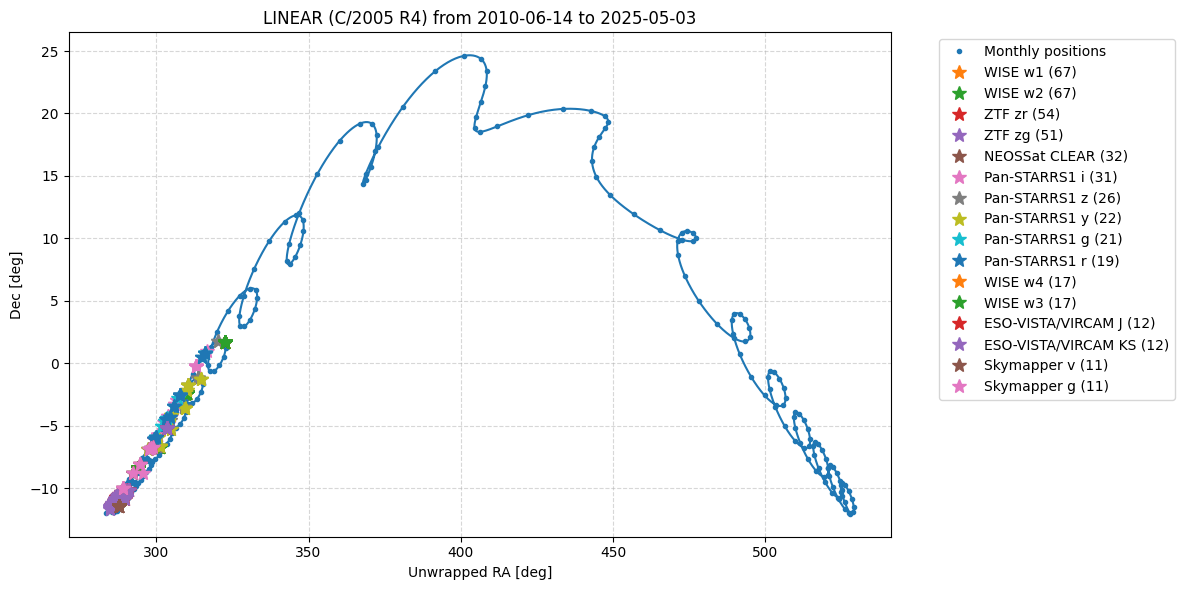

In [74]:
# undo RA-wrapping from 0-360 degrees
# add or subtract multiples of 360 to create a smooth path
njumps = 0
ra_deg = df_jplh['RA'].to_numpy(copy=True)

# Count wrap jumps in the original series (optional)
d = np.diff(ra_deg)
njumps = int((d > 180).sum() + (d < -180).sum())

# Unwrap using numpy (threshold = 180 deg)
ratab = np.rad2deg(np.unwrap(np.deg2rad(ra_deg), discont=np.deg2rad(180)))

# Shift to non-negative range
if ratab.min() < 0:
    ratab += 360.0 * np.ceil(-ratab.min() / 360.0)

# plt.rcParams.update({"font.size":14})
plt.figure(1, (12, 6))
plt.plot(ratab, df_jplh['DEC'])

# plot every 30 days as a dot to see movement
mstep = int(30 / (df_jplh['datetime_jd'][1] - df_jplh['datetime_jd'][0]) + 0.5)
plt.plot(ratab[::mstep], df_jplh['DEC'][::mstep], '.', color="tab:blue", label="Monthly positions")

# show positions at the times of observations
jpl_mjd = Time(df_jplh['datetime_jd'], format='jd').mjd
ra_interp = np.interp(df['MJD'], jpl_mjd, ratab)
dec_interp = np.interp(df['MJD'], jpl_mjd, df_jplh['DEC'])

df_instr = df[['Telescope/Instrument', 'Filter']].value_counts()
df_instr = df_instr[df_instr > 10]
for (instr, filt), count in df_instr.items():
    cond = (df['Telescope/Instrument'] == instr) & (df['Filter'] == filt)
    plt.plot(ra_interp[cond], dec_interp[cond], '*', markersize=10,
             label=f"{instr} {filt} ({count})")

plt.xlabel("Unwrapped RA [deg]")
plt.ylabel("Dec [deg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"{fullname} from {emin.isot[:10]} to {emax.isot[:10]}")
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)
# if saveplots:
#     plt.savefig("sky_path.png", facecolor="white")
plt.show()

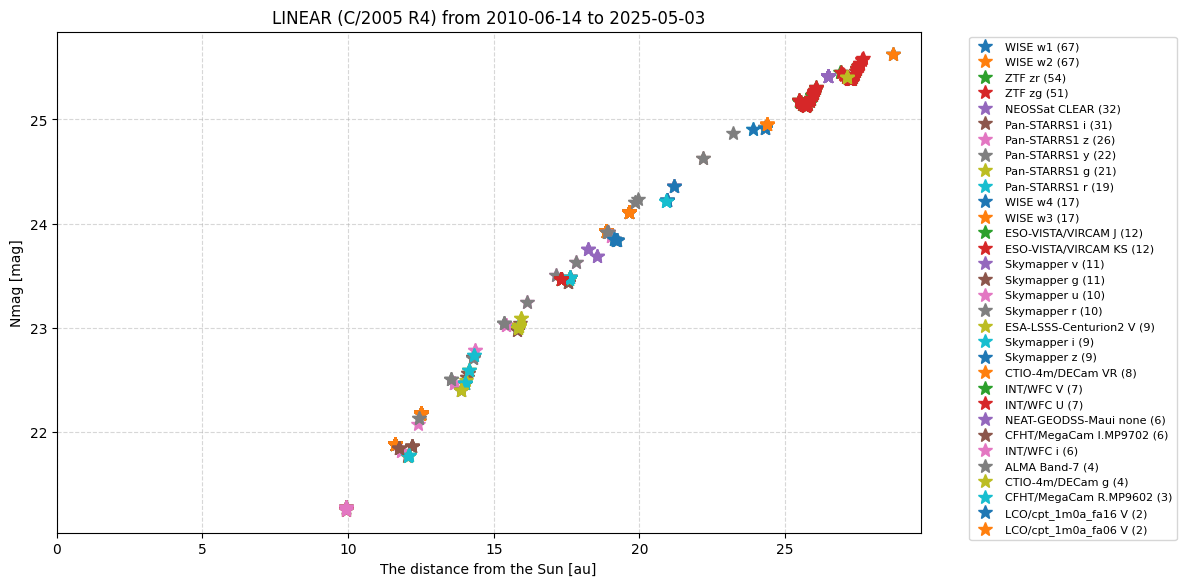

In [75]:
phase_interp = np.interp(df_cadc['MJD'], jpl_mjd, df_jplh['alpha']) 
# Nmag
nmag_interp = np.interp(df_cadc['MJD'], jpl_mjd, df_jplh['Nmag'])
# distance from the Sun
r_interp = np.interp(df_cadc['MJD'], jpl_mjd, df_jplh['r'])

# plt.rcParams.update({"font.size":14})
plt.figure(1,(12,6))
# plt.plot(ratab, jpltab['DEC'])

df_instr = df_cadc[['Telescope/Instrument', 'Filter']].value_counts()
df_instr = df_instr[df_instr > 1]
for (instr, filt), count in df_instr.items():
    cond = (df_cadc['Telescope/Instrument'] == instr) & (df_cadc['Filter'] == filt)
    plt.plot(
        # phase_interp[cond], 
        r_interp[cond],
         nmag_interp[cond], 
        '*', markersize=10,
        label=f"{instr} {filt} ({count})")
# plt.plot(ra_interp, dec_interp, 'o', color="tab:orange", label=f"{len(df)} observations")

plt.xlabel("The distance from the Sun [au]")
plt.ylabel("Nmag [mag]")
plt.xlim(left=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title(f"{fullname} from {emin.isot[:10]} to {emax.isot[:10]}")
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)
# if saveplots:
#     plt.savefig("sky_path.png", facecolor="white")
plt.show()
